### Задание 2
**Перед тобой датасет некой интернет-компании. Загрузи его в Python или R, ознакомься с данными и ответь на приведенные ниже вопросы. Для ответа на некоторые из них понадобится произвести расчеты, ход которых опиши в файле с кодом.**

In [ ]:
#Импортируем нужные библиотеки

import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import date
from  scipy.stats import chi2_contingency
import holidays
from fbprophet import Prophet


%matplotlib inline

In [ ]:
#Выгружаем датафрейм (далее - ДФ) из CSV

df = pd.read_csv('summer_camp_data.csv', encoding='windows-1251')

In [ ]:
# Проверяем первые 5 строк ДФ

df.head()

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
0,2020-05-11,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0
4,2020-05-11,yandex,organic,Не определено,Десктоп,no,no,2159,1000,4110,824,351,62,61861.0


In [ ]:
# Проверяем информацию о ДФ

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52724 entries, 0 to 52723
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                52724 non-null  object 
 1   source              52724 non-null  object 
 2   medium              52724 non-null  object 
 3   delivery_available  52724 non-null  object 
 4   device_type         52724 non-null  object 
 5   promo_activated     52724 non-null  object 
 6   filter_used         52724 non-null  object 
 7   pageviews           52724 non-null  int64  
 8   visits              52724 non-null  int64  
 9   productClick        52724 non-null  int64  
 10  addToCart           52724 non-null  int64  
 11  checkout            52724 non-null  int64  
 12  transactions        52724 non-null  int64  
 13  revenue             52724 non-null  float64
dtypes: float64(1), int64(6), object(7)
memory usage: 5.6+ MB


In [ ]:
# Проверяем описательную статистику ДФ

df.describe()

,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
count,52724.000000,52724.000000,52724.000000,52724.00000,52724.000000,52724.000000,5.272400e+04
mean,445.797853,127.219312,891.086981,178.04074,146.593620,20.092823,2.419841e+04
std,1108.633081,385.094298,2101.027285,419.99282,344.664158,52.436046,6.382118e+04
min,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00
25%,12.000000,2.000000,20.000000,4.00000,3.000000,0.000000,0.000000e+00
50%,47.000000,7.000000,90.000000,18.00000,15.000000,2.000000,2.445500e+03
75%,256.000000,41.000000,520.000000,104.00000,83.000000,11.000000,1.329775e+04
max,26589.000000,6975.000000,32460.000000,6486.00000,3857.000000,1113.000000,1.397420e+06


**a. Какой рекламный канал принёс больше всего дохода за всё время?**

In [ ]:
revenue_per_channel = df.groupby('source')\
                        .agg(total_revenue=('revenue','sum'))\
                        .idxmax()
revenue_per_channel

total_revenue    yandex
dtype: object

**b.1. Как изменился средний чек транзакции после введения коронавирусных ограничений?**

In [ ]:
# Создаем колонку "выручка на транзакцию"

df['revenue_per_transaction'] = df.revenue.div(df.transactions)

In [ ]:
# Изменяем формат колонки 'date' на datetime для корректного оформления оси Х графиков

df['date'] = pd.to_datetime(df.date)

In [ ]:
# Высчитываем средний чек транзакции с группировкой по дате

avg_revenue_per_transaction = df.groupby('date')\
                                .agg({'revenue_per_transaction':'mean'})

In [ ]:
# Устанавливаем настройки графика

sns.set(font_scale = 1.5,
        rc         = {'figure.figsize':(20,7)})

sns.set_style('darkgrid',
             {'axes.facecolor': '0.9',
              'grid.color': '0.5',
              'figure.facecolor': '0.95'})

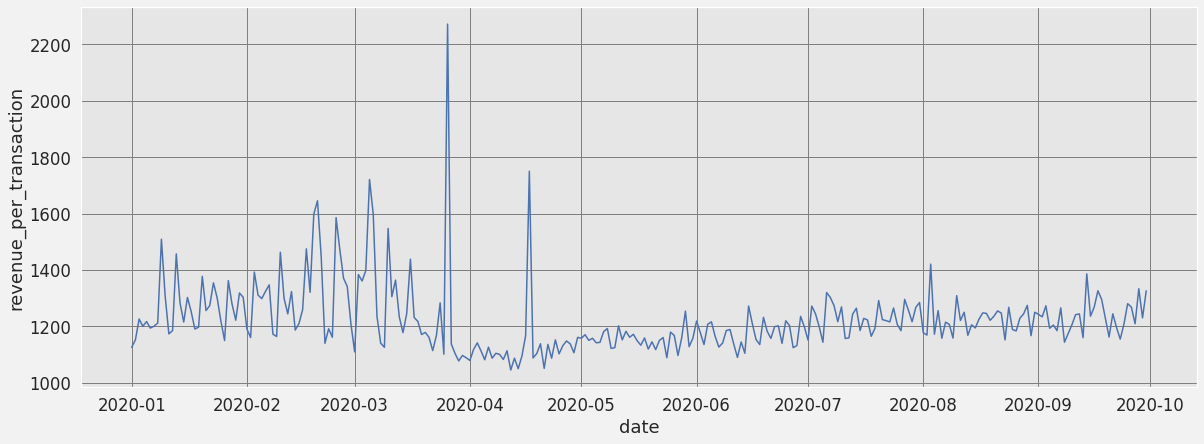

In [ ]:
# Строим график

ax = sns.lineplot(data = avg_revenue_per_transaction, x = 'date', y = 'revenue_per_transaction')

# График "зашумлен"

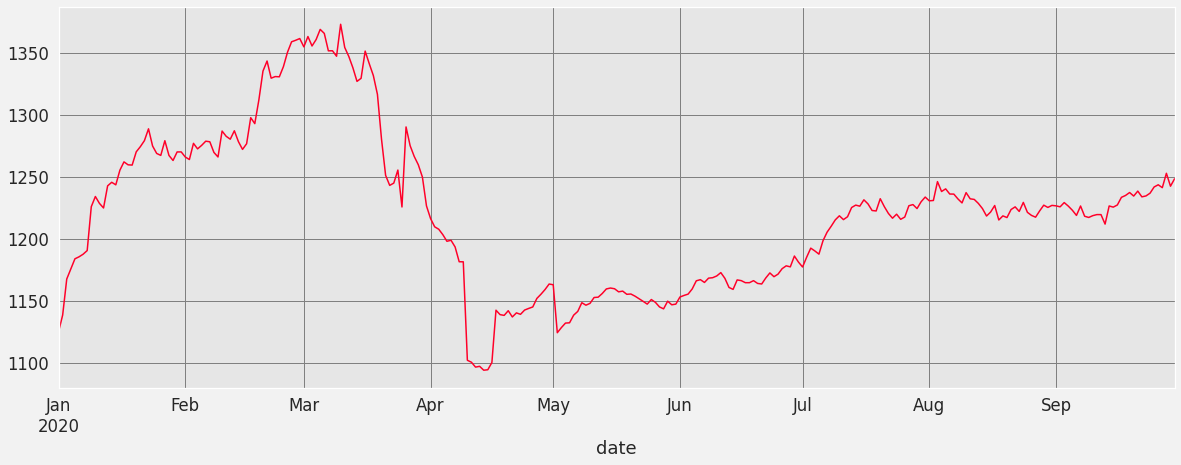

In [ ]:
# Для получения более наглядного графика находим скользящее среднее с окном 15 дней, строим график

avg_revenue_per_transaction.revenue_per_transaction.rolling(15, min_periods=1).mean().plot(colormap = 'gist_rainbow') # Красный


**Вывод:** после введения коронавирусных ограничений наблюдается резкий спад (200-250 пунктов) среднего чека транзакции.

**b.2. Как изменился средний чек транзакции для пользователей, покупающих с промокодом и без? (параметр «promo_activated»)**

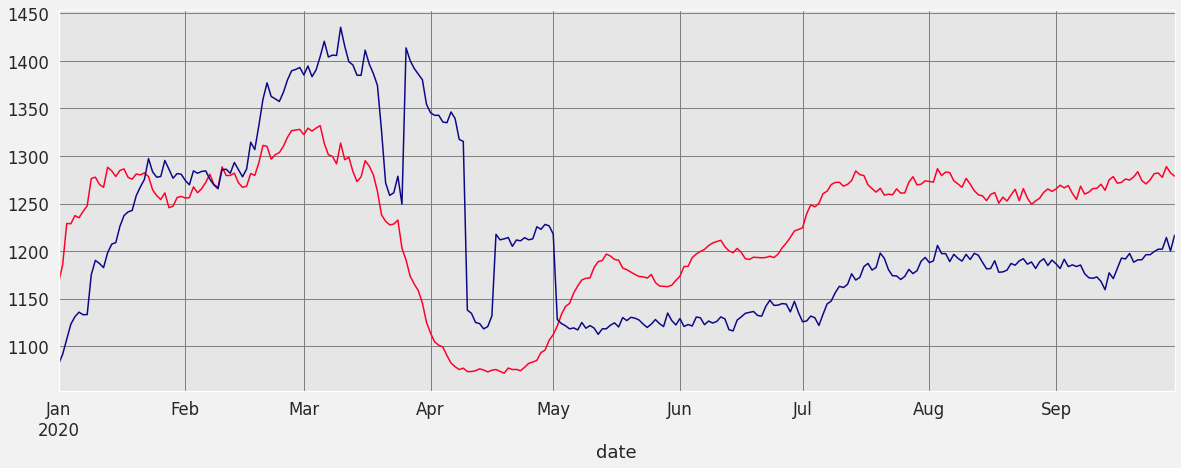

In [ ]:
# График для данных с параметром «promo_activated» = yes - Красный

df.query("promo_activated == 'yes'")\
  .groupby('date')\
  .agg({'revenue_per_transaction':'mean'})\
  .revenue_per_transaction\
  .rolling(15, min_periods=1)\
  .mean().plot(colormap = 'gist_rainbow')

# График для данных с параметром «promo_activated» = no - Синий

df.query("promo_activated == 'no'")\
  .groupby('date')\
  .agg({'revenue_per_transaction':'mean'})\
  .revenue_per_transaction\
  .rolling(15, min_periods=1)\
  .mean().plot(colormap = 'plasma')

**Вывод:** после введения коронавирусных ограничений наблюдается спад среднего чека транзакции как для транзакций с прокодом, так и без. Однако, после спада средний чек транзакции с промокодом практически вернулся к значениям до введения ограничений,тогда как средний чек транзации без промокода такого восстановления не имел.

**c.	Можно ли с уверенностью в 95% сказать, что CR (коэффициент конверсии в транзакцию) в выходные дни отличается от CR в будние дни?**

Для ответа на данный вопрос нужно удостовериться в стат. значимости различий конверсии в выходные и будние дни.

In [ ]:
df.head()

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue,revenue_per_transaction
0,2020-05-11,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0,962.766667
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0,1126.626728
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0,1051.500000
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0,1112.718310
4,2020-05-11,yandex,organic,Не определено,Десктоп,no,no,2159,1000,4110,824,351,62,61861.0,997.758065


In [ ]:
#Соберем количество пользователей на каждом шаге воронки за каждую дату
df_groupped = df.groupby('date', as_index=False) \
                .agg({'pageviews': 'sum', 'visits': 'sum', 'productClick': 'sum', 'addToCart': 'sum', 'checkout': 'sum', 'transactions': 'sum'})
df_groupped.head()

,date,pageviews,visits,productClick,addToCart,checkout,transactions
0,2020-01-01,62709,21736,131780,26354,18920,3107
1,2020-01-02,80623,27774,170190,34018,24013,4208
2,2020-01-03,81987,28168,172520,34476,23881,4260
3,2020-01-04,85679,29164,186350,37240,24949,4549
4,2020-01-05,83842,28360,180290,36026,24861,4498


In [ ]:
#Создадим признак выходной день или нет
df_groupped['weekend'] = 0
df_groupped.head()

,date,pageviews,visits,productClick,addToCart,checkout,transactions,weekend
0,2020-01-01,62709,21736,131780,26354,18920,3107,0
1,2020-01-02,80623,27774,170190,34018,24013,4208,0
2,2020-01-03,81987,28168,172520,34476,23881,4260,0
3,2020-01-04,85679,29164,186350,37240,24949,4549,0
4,2020-01-05,83842,28360,180290,36026,24861,4498,0


In [ ]:
#Где выходной - 1, где будний - 0
df_groupped.loc[df_groupped.date.dt.day_name() == 'Saturday', 'weekend'] = 1
df_groupped.loc[df_groupped.date.dt.day_name() == 'Sunday', 'weekend'] = 1
df_groupped.head()

,date,pageviews,visits,productClick,addToCart,checkout,transactions,weekend
0,2020-01-01,62709,21736,131780,26354,18920,3107,0
1,2020-01-02,80623,27774,170190,34018,24013,4208,0
2,2020-01-03,81987,28168,172520,34476,23881,4260,0
3,2020-01-04,85679,29164,186350,37240,24949,4549,1
4,2020-01-05,83842,28360,180290,36026,24861,4498,1


Будем исследовать значение конверсии на шаге  pageviews -> transactions

In [ ]:
#Суммируем пользователей на шагах 'pageviews' и 'transactions' в зависимости от значения признака 'weekend'

df_groupped_weekend = df_groupped.groupby('weekend', as_index = False) \
                                 .agg({'pageviews': 'sum', 'transactions': 'sum'})
df_groupped_weekend

,weekend,pageviews,transactions
0,0,15691196,691164
1,1,7813050,368210


In [ ]:
#Считаем конверсию из просмотра страницы в транзакцию
df_groupped_weekend['CR'] = df_groupped_weekend.transactions * 100 / df_groupped_weekend.pageviews
df_groupped_weekend

,weekend,pageviews,transactions,CR
0,0,15691196,691164,4.404789
1,1,7813050,368210,4.712756


Видим, что конверсия в выходные дни выше на 0.3%. Проверим является ли эта разница стат. значимой.
Для оценки стат. значимости различий конверсии в группах используем критерий хи-квадрат.
За нулевую гипотезу принимается отсутствие различий конверсии в группах.

In [ ]:
#Преобразуем данные в массив для работы со стат. методом
kf_data = np.array([[df_groupped_weekend.pageviews[0], df_groupped_weekend.transactions[0]], 
                    [df_groupped_weekend.pageviews[1], df_groupped_weekend.transactions[1]]])

In [ ]:
#В данном случае по умолчанию уровень значимости равен 5%
kf = chi2_contingency(kf_data)
print(f'Значение статистики хи-квадрат: {kf[0]}')
print(f'P-value: {kf[1]}')

Значение статистики хи-квадрат: 1049.14488704198
P-value: 3.7341501632639707e-230


**Вывод:** Так как при выбранном уровне значимости (5%) значение p-value < 0.05, то мы можем отвергнуть нулевую гипотезу. Конверсии в группах стат. значимо различаются. В выходные конверсия в транзакцию выше.

**d. Вам необходимо спрогнозировать объем дохода, полученного с пользователей, приведенных на сайт контекстной рекламой (medium = cpc) на полгода вперед. Опишите, как бы вы подошли к этой задаче и какие дополнительные данные вам понадобятся?**

   Для решения данной задачи можно использовать библиотеку для прогнозирования временных рядов Prophet, которая использует для построения прогноза аддитивную регрессионную модель:  
    Y(t) = a(t) + b(t) + c(t) + Err, где:
    
   a(t) - сезонные компоненты (годовые, месячные, недельные и т.д.).  
   b(t) - тренд, где учитываются как исторические данные, так и события заданные вручную (например релиз нового функционала ПО/услуги/продукта).  
   c(t) - аномалии (регулярные и нерегулярные).  
   Err - ошибка - содержит информацию, которая не учтена моделью.  
    
   Таким образом для того, чтобы построить качественный прогноз желательно наличие следующих данных:
   - Инфо о сезонных колебаниях спроса на рекламируемый товар или услугу (с учетом праздничных дней).
   - Исторические данные о ситуации на исследуемом рынке, инфо о бюджетах рекламных компаний (прошлых и предстоящих), данные по конверсии и другим метрикам прошлых компаний для выявления трендов. Чем больше данных, тем лучше,но ценность "свежих" данных выше.
   - Инфо о предстоящих событиях (например, релиз нового продукта, ребрендинг).
   - Инфо о том, как ведут себя покупатели в аномальные дни (например Black Friday).
   - Модель влияния коронавируса и связанных с ним ограничений на исследуемый рынок.
   - Анализ рисков исследуемого рынка для построения нескольких вариантов прогноза: позитивного, умеренного и негативного.
    